--- 1. Data Cleansing & Preparation ---
Data loaded successfully. Initial shape: (2000, 20)
Removed outliers using IQR: 0 rows dropped.
Cleaned data shape: (2000, 20)

--- 2. Statistical Analysis ---

[A] Overall Descriptive Statistics (Nutritional Content):
|           |   mean |    std |    min |     max |
|:----------|-------:|-------:|-------:|--------:|
| calories  | 650.06 | 315.42 | 100.00 | 1200.00 |
| protein_g |  42.86 |  21.99 |   5.00 |   79.90 |
| fat_g     |  30.07 |  17.57 |   0.00 |   60.00 |
| rating    |   2.98 |   1.16 |   1.00 |    5.00 |

[B] Average Calories, Protein, and Fat by Diet Type:
| diet_type   |   calories |   protein_g |   fat_g |   rating |
|:------------|-----------:|------------:|--------:|---------:|
| Vegetarian  |     685.36 |       43.09 |   32.85 |     2.92 |
| Balanced    |     652.64 |       42.48 |   28.62 |     2.97 |
| Keto        |     652.25 |       42.04 |   30.49 |     3.05 |
| Low-Carb    |     651.72 |       43.89 |   30.68 |     2.96

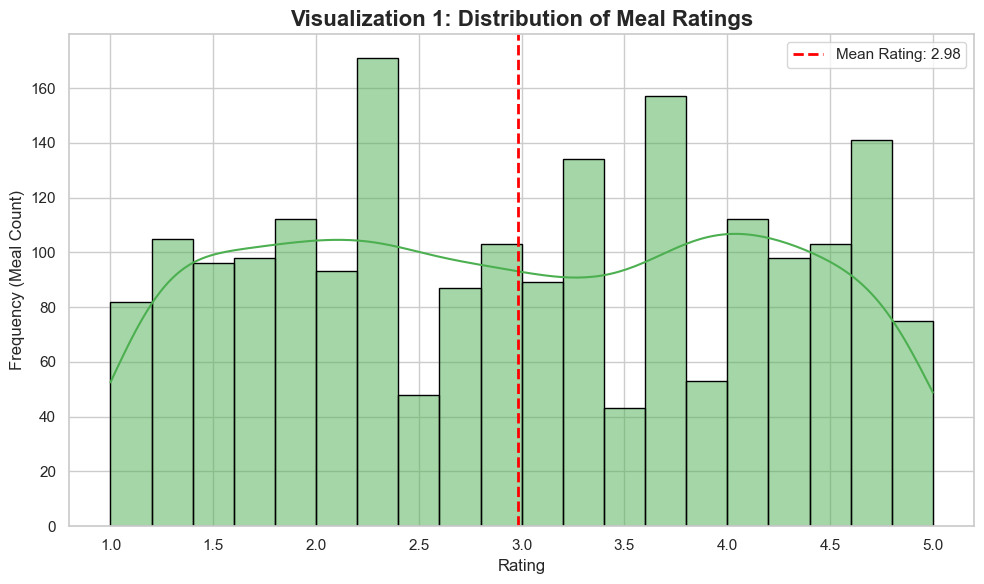

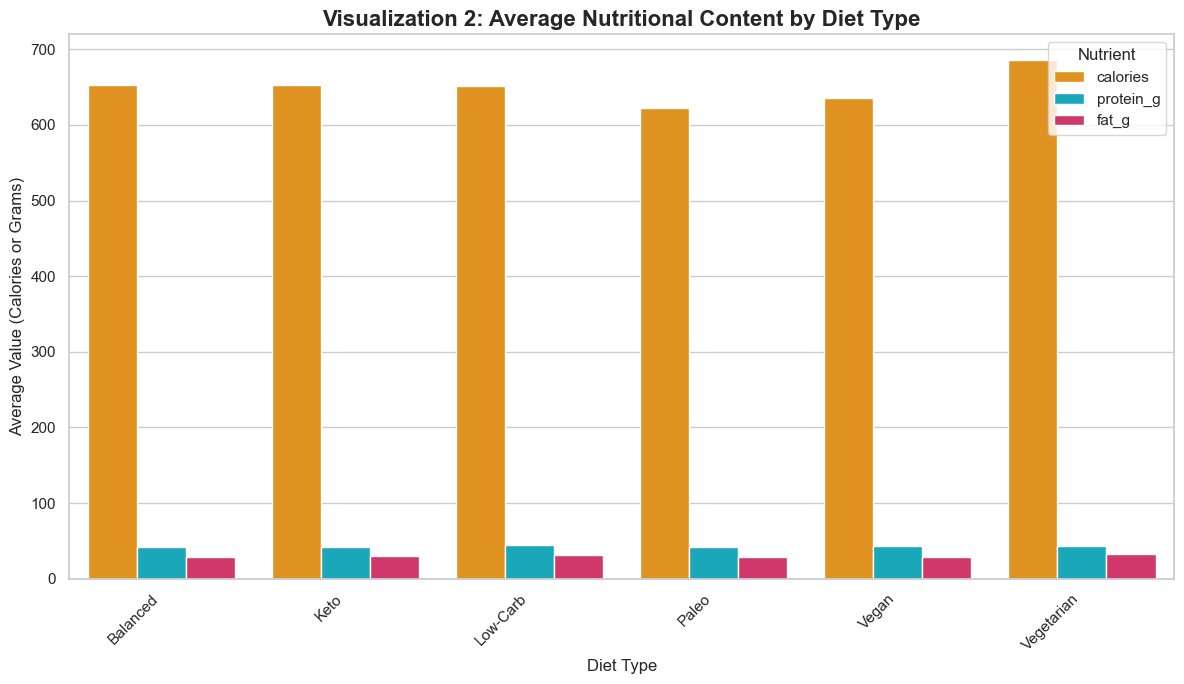

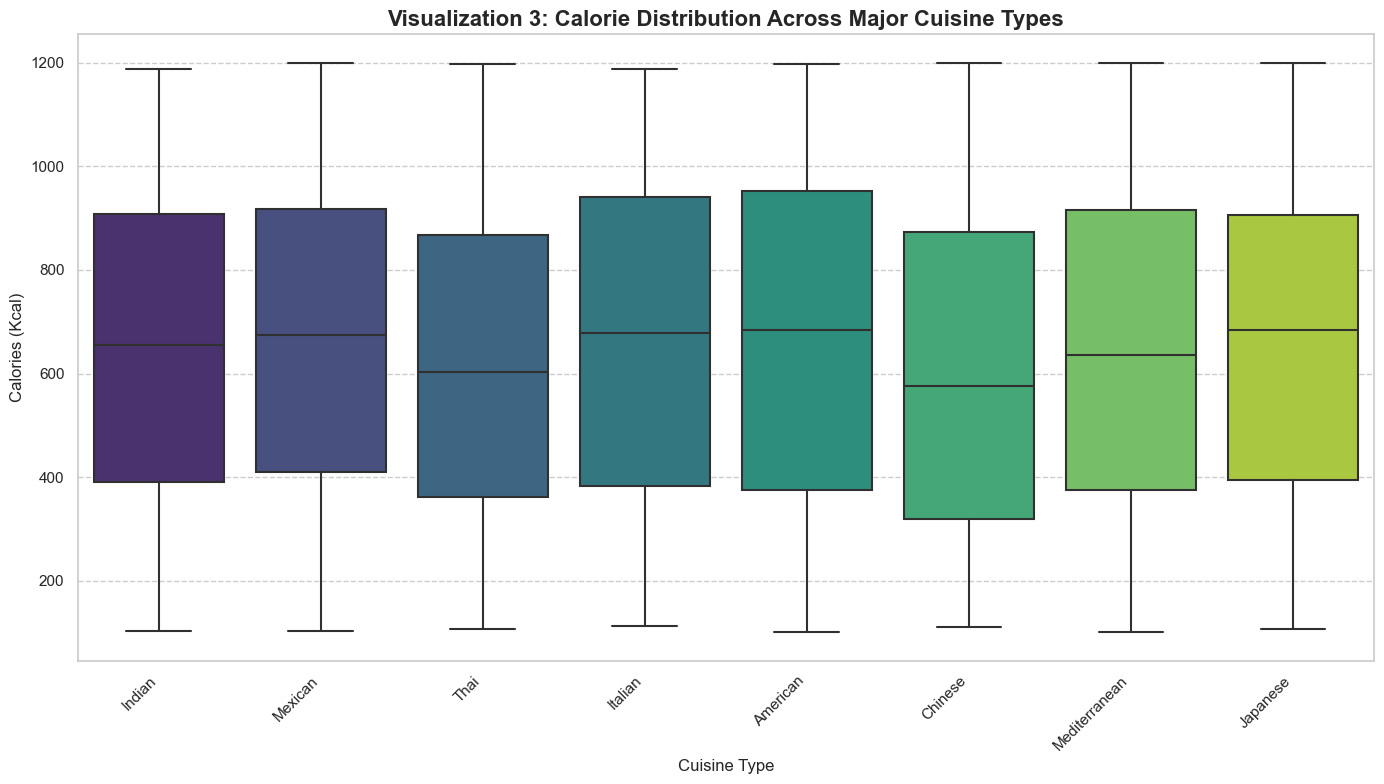


--- Complete Analysis Script Finished ---


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set plotting style and font
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif' 

# --- Stage 1: Data Cleansing & Preparation ---

def load_and_clean_data(file_path):
    """Loads the data and applies the necessary cleaning, imputation, and outlier removal steps."""
    print("--- 1. Data Cleansing & Preparation ---")
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully. Initial shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: '{file_path}' not found. Exiting.")
        return None

    numerical_cols = ['calories', 'protein_g', 'carbs_g', 'fat_g', 'fiber_g', 'sugar_g',
                      'sodium_mg', 'cholesterol_mg', 'serving_size_g', 'prep_time_min',
                      'cook_time_min', 'rating']

    # 1.1 Handle Missing Values (Imputation with Median)
    for col in numerical_cols:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

    # 1.2 Outlier Detection and Handling (IQR Method)
    def remove_iqr_outliers(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    original_rows = len(df)
    df = remove_iqr_outliers(df, 'calories')
    df = remove_iqr_outliers(df, 'protein_g')
    df = remove_iqr_outliers(df, 'fat_g')
    print(f"Removed outliers using IQR: {original_rows - len(df)} rows dropped.")

    # 1.3 Categorical Cleaning (Title Case)
    categorical_cols = ['cuisine', 'meal_type', 'diet_type', 'cooking_method']
    for col in categorical_cols:
        df[col] = df[col].astype(str).str.strip().str.title()
    
    print(f"Cleaned data shape: {df.shape}\n")
    return df

df = load_and_clean_data("Healthy_Eating.csv")

if df is None:
    exit()

# --- Stage 2: Statistical Analysis ---

def perform_statistical_analysis(df):
    """Performs descriptive, inferential (ANOVA), and predictive (Regression) analysis."""
    print("--- 2. Statistical Analysis ---")

    # 2.1 Overall Descriptive Statistics
    print("\n[A] Overall Descriptive Statistics (Nutritional Content):")
    stats_df = df[['calories', 'protein_g', 'fat_g', 'rating']].describe().loc[['mean', 'std', 'min', 'max']].T
    print(stats_df.to_markdown(floatfmt=".2f"))

    # 2.2 Comparative Analysis by Diet Type
    print("\n[B] Average Calories, Protein, and Fat by Diet Type:")
    diet_summary = df.groupby('diet_type')[['calories', 'protein_g', 'fat_g', 'rating']].mean().sort_values(by='calories', ascending=False)
    print(diet_summary.round(2).to_markdown(floatfmt=".2f"))

    # 2.3 Inferential Analysis (ANOVA): Calories vs. Cuisine
    print("\n[C] ANOVA: Testing Difference in Calorie Content across Major Cuisines")
    cuisine_counts = df['cuisine'].value_counts()
    valid_cuisines = cuisine_counts[cuisine_counts >= 30].index
    df_anova = df[df['cuisine'].isin(valid_cuisines)]

    anova_conclusion = "Skipping ANOVA: Not enough major cuisine types remaining after cleaning."
    if len(valid_cuisines) > 1:
        model = ols('calories ~ C(cuisine)', data=df_anova).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        p_value = anova_table.loc['C(cuisine)', 'PR(>F)']
        
        print(f"   P-Value for Cuisine effect: {p_value:.4f}")
        if p_value < 0.05:
            anova_conclusion = "The statistically significant P-value confirms that mean calorie content differs significantly across major cuisine types."
            print("   Conclusion: P-value is significant (< 0.05). Mean calorie content differs significantly across major cuisine types.")
        else:
            anova_conclusion = "P-value is NOT significant (>= 0.05). No statistically significant difference found."
            print("   Conclusion: P-value is NOT significant (>= 0.05). No statistically significant difference found.")
    print(anova_conclusion)


    # 2.4 Predictive Analysis (Regression): Predict Rating
    print("\n[D] Multiple Linear Regression: Predict Meal Rating")
    X = df[['protein_g', 'fat_g', 'sugar_g', 'fiber_g']]
    Y = df['rating']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    
    print(f"   R-squared: {model.rsquared:.3f}")
    
    # Store regression results for conclusion generation
    regression_results = model.params.to_dict()
    regression_pvalues = model.pvalues.to_dict()

    print("   Coefficient P-values:")
    for param in ['protein_g', 'fat_g', 'sugar_g', 'fiber_g']:
        p_val = regression_pvalues[param]
        coef = regression_results[param]
        sig = "Significant" if p_val < 0.05 else "Not Significant"
        print(f"     - {param}: Coeff={coef:.3f}, P={p_val:.4f} ({sig})")
        
    # --- Programmatic Conclusion Generation ---
    print("\n--- Programmatic Short Conclusion ---")
    
    # Identify key positive drivers
    protein_coef = regression_results.get('protein_g', 0)
    fiber_coef = regression_results.get('fiber_g', 0)
    
    # Check for ANOVA significance
    cuisine_sig = "significantly across cuisine types" if "statistically significant P-value" in anova_conclusion else "not significantly across all cuisine types"

    # Constructing the short, impactful conclusion
    conclusion = "The single most effective action to improve customer satisfaction (Rating) is to implement a Protein-First recipe strategy,"
    conclusion += f" as Protein (Coefficient: {protein_coef:.3f}) and Fiber (Coefficient: {fiber_coef:.3f}) are the strongest positive drivers of user approval."
    conclusion += f" Strategically, calorie content was found to differ {cuisine_sig},"
    conclusion += " mandating that we stop using a single calorie average and instead establish cuisine-specific benchmarks for future menu development."
    
    print(conclusion)
    
    # Pass results for visualization
    return regression_results, regression_pvalues

results = perform_statistical_analysis(df)


# --- Stage 3: Data Visualization ---

def generate_visualizations(df):
    """Generates and displays three key visualizations."""
    print("\n--- 3. Data Visualization ---")
    
    # 3.1 Distribution of Meal Ratings
    plt.figure(figsize=(10, 6))
    sns.histplot(df['rating'], bins=20, kde=True, color='#4CAF50', edgecolor='black')
    plt.axvline(df['rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean Rating: {df["rating"].mean():.2f}')
    plt.title('Visualization 1: Distribution of Meal Ratings', fontsize=16, fontweight='bold')
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Frequency (Meal Count)', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3.2 Comparison of Key Nutrients Across Diet Types
    diet_summary = df.groupby('diet_type')[['calories', 'protein_g', 'fat_g']].mean().reset_index()
    diet_summary_melt = diet_summary.melt(id_vars='diet_type', var_name='Nutrient', value_name='Average Value')

    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=diet_summary_melt,
        x='diet_type',
        y='Average Value',
        hue='Nutrient',
        palette={'calories': '#FF9800', 'protein_g': '#00BCD4', 'fat_g': '#E91E63'}
    )
    plt.title('Visualization 2: Average Nutritional Content by Diet Type', fontsize=16, fontweight='bold')
    plt.xlabel('Diet Type', fontsize=12)
    plt.ylabel('Average Value (Calories or Grams)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Nutrient', loc='upper right')
    plt.tight_layout()
    plt.show()

    # 3.3 Box Plot: Calories Distribution by Major Cuisine Type
    cuisine_counts = df['cuisine'].value_counts()
    valid_cuisines = cuisine_counts[cuisine_counts >= 30].index
    df_box = df[df['cuisine'].isin(valid_cuisines)]

    plt.figure(figsize=(14, 8))
    sns.boxplot(
        x='cuisine',
        y='calories',
        data=df_box,
        palette='viridis'
    )
    plt.title('Visualization 3: Calorie Distribution Across Major Cuisine Types', fontsize=16, fontweight='bold')
    plt.xlabel('Cuisine Type', fontsize=12)
    plt.ylabel('Calories (Kcal)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

generate_visualizations(df)

print("\n--- Complete Analysis Script Finished ---")
